# Bayesian Treatment and Response Modeling

The basic idea in this worksheet (and in subsequent ones) is to develop a means of modelling unobserved heterogeneity and selectivity effects in the usual treatment and response model. 

### Latent variables

The method that I will rely on involves _latent variables_ and in particular drawing from the distribution of latent variables. The best way to explain what this means is to simply dive in. 

### A simple linear model

To start, let's take a look at a simple linear model with a response equation:

$$
y_i = X_i \beta + \delta z_i + \epsilon_{yi}
$$

and a treatment equation

$$
z_i = W_i \eta + \epsilon_{zi}
$$

So, the second equation explains how the treatment varies across individuals, and the first explains the effectiveness of treatment. One hopes that $Cov(\epsilon_y,\epsilon_z)=0$, so that inferences about the conditional impact of $z$ on $y$ is valid. However, there are often reasons to doubt this. 

### Bayesian methods and latent variables

One of the great things about Bayesian methods is that one can quantify beliefs about how seriously one believes in conditional independence. As a quick review and to present some details, one is typically interested in some set of parameters in a model. In the above model, the list of parameters includes $\theta = \beta,\delta,\eta,\sigma_y,\sigma_z$, which are related to the model data $D = y,X,W$. Most methods of estimation  rely on maximizing a function of the data and parameters. For example, maximum likelihood uses probability theory to create a likelihood function:

$$
L = f(D|\theta)
$$

which is then maximized w. r. t. $\theta$. The idea is to get the parameters that maximize the likelihood of observing the data. Once these maximizing parameters are obtained, some calculus and probability theory is used to derive the distribution of the parameters at the maximum. 

Bayesian methods are in some sense more direct. We start by acknowledging we are interested in the distribution of the parameters of the model, or in my model, really one parameter: $\delta$, the treatment effect. As it happens, the distribution of the parameters kind of falls out of Bayes's rule in conjunction with the likelihood function. What is the distribution for the parameters? Bayes's rule says that:

$$
f(D|\theta)f(\theta) = f(\theta|D)f(D)
$$

Or

$$
f(\theta|D) = \frac{f(D|\theta)f(\theta)}{f(D)}
$$

This last thing is usually written as:

$$
f(\theta|D) \propto f(D|\theta)f(\theta)
$$

owing to the fact that $f(D)$ does not depend upon parameters and is just a constant given the data. There are two things to note about this last equation:

1. If we can characterize the parameter distribution directly, why go through the often difficult process of maximizing likelihood, and why not just use the parameter distribution? 

2. Note the presence of $f(\theta)$. This is commonly called a prior distribution of the parameters. In the Treatment-response case, for example, we might wish to somehow characterize our prior belief that the covariance in errors is zero. 

A further note: [A great paper by Chernozhukov and Hong (2003)](http://papers.ssrn.com/sol3/papers.cfm?abstract_id=420371) shows how one can rely on 1., coupled with MCMC, to estimate otherwise difficult models. [An equally great (!) paper by myself (Baker, 2014)](http://www.stata-journal.com/article.html?article=st0354) discusses some practical examples of stuff like this. 

## Practicalities

As a practical matter, one often does a couple of things to actually implement a Bayesian method, but at the heart of most Bayesian methods is some sort of Markov-chain Monte Carlo (Gibbs, Metropolis-Hastings being common variants) sampling routine. These allow sampling from conditional distributions, which are often easy to work with. There are many proofs out there of convergence. But at this point, suffice it to say that I'm going to describe one of these that uses _latent variables_ for the IV problem. A good place to start with this is by first fleshing out our model, and then looking at the implied likelihood. 

### Latent variable

To begin with, let's first add in an unobserved variable that captures the correlation across our equations. To do this, we suppose that:

$$
\epsilon_{yi} = \pi u_i + e_{yi}
$$
and
$$
\epsilon_{zi} = u_i + e_{zi}
$$

Here, the latent variable is $u_i$, which is something that we don't see about the individual but is present in both equations. We assume that $E[u_i] = E[e_{yi}] = E[e_{zi}] = 0$, and that $E[u_i^2] = 1, E[e_{yi}^2] = \sigma_y^2,$ and $E[e_{zi}^2] = \sigma_z^2$. This gives us a variance matrix across the two equations of:

$$
\Sigma = \left[\begin{array}{cc}
\sigma_y^2 + \pi^2 & \pi \\
\pi & 1 + \sigma_z^2
\end{array} \right]
$$

Note that I have assumed that the distribution of the latent variable $u_i$ is known to be a standard normal random variable. This is because the parameter $\pi$, which captures correlation across the equations, cannot be separately identified in the model. Anyways, given that we have observed. This idea borrows a bit from [Heckman et. al.](http://www.ncbi.nlm.nih.gov/pubmed/24187431) 

Anyways, given this latent variable, one way of writing down the full likelihood of our model is:

$$
LL =\Pi_{i=1}^N \int_u \frac{e^{-\frac{(y_i-\beta X_i-\delta z_i-\pi u_i)}{2\sigma_y^2}}}{\sqrt{2\pi\sigma_y^2}}
     \frac{e^{-\frac{(z_i-\eta W_i-u_i)}{2\sigma_z^2}}}{\sqrt{2\pi\sigma_z^2}} \frac{e^{-\frac{u_i^2}{2}}}{\sqrt{2\pi}}du_i  \times Prior(\beta,\pi,\delta,\sigma)
$$

Note that we have to integrate out the unobserved latent variable. In fact, this suggests that one way to estimate the model - just compute the above, and then use it as part of a likelihood routine. 

While there is nothing wrong with that, a Bayesian approach is interesting to do, and is also easily extendable to other possibilities, dichotomous outcomes, different sorts of distributions, etc. So, let's now present an Gibbs sampling approach based on the above. The idea is to assume everything but a given set of the things of interest is given, and think about conditional distributions. So:

## Sampling algorithm

1. Conditional on $X,y,u$ and $\sigma_y$, and a normal prior $ \beta,\delta = (\beta_p,\delta) \sim N(0,T_y) $ are just regular regression parameters, so they follow a multivariate normal distribution. That is, take $X_u = X,u$ and let $\beta_d = \beta,\delta$. Then, we have the conditional distribution of $\beta_d$ as MVN, with mean $(X_u'X_u+\sigma_y^2T_y^{-1})^{-1}X_u'y$ and variance $(Xu'Xu + \sigma_y^2T^{-1})^{-1}\sigma_y$. 
2. Conditional on $W,u$, and $\sigma_z$, we see that $\eta$ also follows a normal with mean $(W'W+\sigma_zT_z^{-1})^{-1}W'(z-u)$ and variance $\sigma_z^2(W'W+\sigma_zT_z^{-1})^{-1}$. 
3. Conditional on everything else, and assuming the usual completely uninformative gamma prior gives us the distribution of $\sigma_y^2$ and $\sigma_z^2$ given everything else, as inverse gamma, with shape parameter $\frac{n}{2}$ and scale parameters $\alpha = \frac{n}{2}$, and $\beta = \frac{e_k'e_k}{2}$, where $e_k, k = y,z$ indicate error terms from our linear equations. 
4. Finally, given everything else, the $u_i$ can be shown to be normal with mean:
$$
\mu_i = \frac{(y_i - X_i\beta)\frac{\pi}{\sigma_y^2}+ \frac{z_i-W_i\eta}{\sigma_z^2}}{\frac{\pi^2}{\sigma_y^2} + \frac{1}{\sigma_z^2} + 1}
$$
and variance 
$$
\frac{1}{\frac{\pi^2}{\sigma_y^2} + \frac{1}{\sigma_z^2} + 1}
$$

So, the idea is pretty simple - just draw from each of these distributions until we think things have converged. 

## A Stata implementation

Here is an example of some `Stata` code that implements all of this in `Mata` [and using the awesome ipystata package](https://github.com/TiesdeKok/ipystata). We begin by just pulling in some data and taking a look at it. This is an example I just pulled right from the help file. The idea is to investigate the relationship between wages and education.

In [1]:
import ipystata

In [2]:
%%stata 
use http://www.stata.com/data/jwooldridge/eacsap/card.dta, clear
set more off
describe


Contains data from http://www.stata.com/data/jwooldridge/eacsap/card.dta
  obs:         3,010                          
 vars:            34                          2 Sep 1996 15:51
 size:       132,440                          
---------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------
id              int     %9.0g                 
nearc2          byte    %9.0g                 =1 if near 2 yr college, 1966
nearc4          byte    %9.0g                 =1 if near 4 yr college, 1966
educ            byte    %9.0g                 years of schooling, 1976
age             byte    %9.0g                 in years
fatheduc        byte    %9.0g                 father's schooling
motheduc        byte    %9.0g                 mother's schooling


Start with just a basic regression, trying to explain the log wage on a whole host of other things. 

In [3]:
%%stata 
regress lwage educ expersq black south smsa reg661-reg668 smsa66, vce(r)


Linear regression                               Number of obs     =      3,010
                                                F(14, 2995)       =      78.94
                                                Prob > F          =     0.0000
                                                R-squared         =     0.2615
                                                Root MSE          =     .38228

------------------------------------------------------------------------------
             |               Robust
       lwage |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        educ |   .0649315   .0036188    17.94   0.000     .0578359    .0720272
     expersq |   .0015429   .0001086    14.20   0.000     .0013299     .001756
       black |  -.1989218   .0183879   -10.82   0.000     -.234976   -.1628676
       south |  -.1567854   .0290306    -5.40   0.000    -.2137073   -.0998636
        smsa |

Let's add to this a basic IV regression. Here, we are going to use `nearc4` for an instrument for education. 

In [4]:
%%stata 
ivregress 2sls lwage (educ=nearc2 nearc4) exper expersq black south smsa reg661-reg668, first


First-stage regressions
-----------------------

                                                Number of obs     =      3,010
                                                F(  15,   2994)   =     182.45
                                                Prob > F          =     0.0000
                                                R-squared         =     0.4776
                                                Adj R-squared     =     0.4749
                                                Root MSE          =     1.9397

------------------------------------------------------------------------------
        educ |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       exper |  -.4122915   .0336857   -12.24   0.000     -.478341    -.346242
     expersq |   .0008479   .0016496     0.51   0.607    -.0023865    .0040824
       black |  -.9451771   .0937141   -10.09   0.000    -1.128928   -.7614267
 

Fair enough...it looks as though education has a strong positive impact on wages. But are we convinced that there isn't some unobserved heterogeneity or correlation across equations? Let's see what our Bayesian method can tell us about this. 

We begin by reading the data into `Mata`, and adding a constant to each equation:

In [5]:
%%stata --mata
    st_view(y=., ., "lwage")
    st_view(t=., ., "educ")
    st_view(X=., ., "educ exper expersq black south smsa reg661-reg668 smsa66")
    st_view(W=., ., "exper expersq black south smsa reg661-reg668 smsa66 nearc2 nearc4")
    X = X, J(rows(y), 1, 1)
    W = W, J(rows(y), 1, 1)

Mata output:

:     st_view(y=., ., "lwage")

:     st_view(t=., ., "educ")

:     st_view(X=., ., "educ exper expersq black south smsa reg661-reg668 smsa66")

:     st_view(W=., ., "exper expersq black south smsa reg661-reg668 smsa66 nearc2 nearc4")

:     X = X, J(rows(y), 1, 1)

:     W = W, J(rows(y), 1, 1)


We will use the basic iv estimates as starting values, so:

In [17]:
%%stata 
reg lwage educ exper expersq black south smsa reg661-reg668 smsa66
mat binit = e(b)
reg educ exper expersq black south smsa reg661-reg668 smsa66 nearc2 nearc4
mat einit = e(b)


      Source |       SS           df       MS      Number of obs   =     3,010
-------------+----------------------------------   F(15, 2994)     =     85.48
       Model |  177.695591        15  11.8463727   Prob > F        =    0.0000
    Residual |  414.946054     2,994  .138592536   R-squared       =    0.2998
-------------+----------------------------------   Adj R-squared   =    0.2963
       Total |  592.641645     3,009  .196956346   Root MSE        =    .37228

------------------------------------------------------------------------------
       lwage |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        educ |   .0746933   .0034983    21.35   0.000     .0678339    .0815527
       exper |    .084832   .0066242    12.81   0.000     .0718435    .0978205
     expersq |   -.002287   .0003166    -7.22   0.000    -.0029079   -.0016662
       black |  -.1990123   .0182483   -10.91   0.

Send those estimates to `Mata`:

In [18]:
%%stata --mata
    b = st_matrix("binit"), 0
    e = st_matrix("einit")

    nb = cols(b)
    ne = cols(e)

Mata output:

:     b = st_matrix("binit"), 0

:     e = st_matrix("einit")

:     ne = cols(e)


Set up a bunch of placeholders, some diffuse priors for parameters, and pick a random seed so results are reproducable. We also set the number of draws at 5000 and just draw a bunch of standard normal random variables for our initial hack at the unobserved terms. I just pick an initial value of one for the variances. 

In [19]:
%%stata --mata
    bHold        = J(0, nb, .)
    eHold        = J(0, ne, .)
    syHold =       J(0, 1, .)
    stHold =       J(0, 1, .)
    piHold =       J(0, 1, .)

    Tb = I(nb)*1000
    Te = I(ne)*1000

    draws = 5000
    ui = rnormal(rows(y),1,0,1)
    sy2 = 1
    st2 = 1

Mata output:

:     bHold        = J(0, nb, .)

:     eHold        = J(0, ne, .)

:     syHold =       J(0, 1, .)

:     stHold =       J(0, 1, .)

:     piHold =       J(0, 1, .)

:     Te = I(ne)*1000

:     ui = rnormal(rows(y),1,0,1)

:     sy2 = 1

:     st2 = 1


## The Algorithm

As a practical matter, I draw first the values of $u_i$, then $b$, then $e$, and then the two variance terms from the inverse gamma distribution (actually, drawn from gamma with inverted parameters). 

In [22]:
%%stata --mata
   for (d=1;d<=draws;d++) {
       bOnly =b[1..nb-1]
       pi = b[nb]
       resy = y-X*bOnly'
       rest = t-W*e'
       A = pi^2/sy2 + 1/st2 + 1
       B = pi*resy/sy2 + rest/st2
       mi = B:/A
       sd = 1/A
       ui = mi + rnormal(rows(mi),1,0,1)*sqrt(sd)
    
       Xu = (X,ui)
       mb = invsym(Xu'Xu + invsym(Tb))*Xu'y
       vb = sy2*invsym(Xu'Xu + invsym(Tb))
       cholb = cholesky(vb)
       b = mb + cholb*rnormal(nb, 1, 0, 1)
       b = b'
                                  
       tHat = t - ui
       me = invsym(W'W + invsym(Te))*W'tHat
       ve = st2*invsym(W'W + invsym(Te))
       chole = cholesky(ve)
       e = me +chole*rnormal(ne, 1, 0, 1)
       e = e'

       shp = rows(y)/2
       scl = (y-Xu*b')'(y-Xu*b')/2
       scl = 1/scl
       sy2 = rgamma(1, 1, shp, scl)

       scl = (t - ui - W*e')'(t - ui - W*e')/2
       scl = 1/scl
       st2 = rgamma(1, 1, shp, scl)
                             
       bHold  =  bHold \ b
       eHold  =  eHold \ e
       syHold =  syHold \ sy2
       stHold =  stHold \ st2
       piHold =  piHold \ b[nb]
    } 

Mata output:

:    for (d=1;d<=draws;d++) {
>        bOnly =b[1..nb-1]
>        pi = b[nb]
>        resy = y-X*bOnly'
>        rest = t-W*e'
>        A = pi^2/sy2 + 1/st2 + 1
>        B = pi*resy/sy2 + rest/st2
>        mi = B:/A
>        sd = 1/A
>        ui = mi + rnormal(rows(mi),1,0,1)*sqrt(sd)
>     
>        Xu = (X,ui)
>        mb = invsym(Xu'Xu + invsym(Tb))*Xu'y
>        vb = sy2*invsym(Xu'Xu + invsym(Tb))
>        cholb = cholesky(vb)
>        b = mb + cholb*rnormal(nb, 1, 0, 1)
>        b = b'
>                                   
>        tHat = t - ui
>        me = invsym(W'W + invsym(Te))*W'tHat
>        ve = st2*invsym(W'W + invsym(Te))
>        chole = cholesky(ve)
>        e = me +chole*rnormal(ne, 1, 0, 1)
>        e = e'
> 
>        shp = rows(y)/2
>        scl = (y-Xu*b')'(y-Xu*b')/2
>        scl = 1/scl
>        sy2 = rgamma(1, 1, shp, scl)
> 
>        scl = (t - ui - W*e')'(t - ui - W*e')/2
>        scl = 1/scl
>        st2 = rgamma(1, 1, shp, scl)
>               

We now have produced a set of draws. What can we do with them now? Well, the first and obvious thing to do is to take a look at the coefficient estimates. An easy way of doing this is to pull all of the variables into `Stata`:

In [26]:
%%stata
preserve
clear
getmata (b*) = bHold
getmata (e*) = eHold
getmata (sy) = syHold
getmata (st) = stHold

Once all the variables are read in, we can summarize them and view these summary statistics as estimates of sorts. So:

In [27]:
%%stata
sum *


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
          b1 |      5,000    .0751657    .0437407  -.0836028   .2287909
          b2 |      5,000    .0851422    .0449647  -.0701143   .2969397
          b3 |      5,000   -.0023008    .0020194  -.0115431   .0046303
          b4 |      5,000   -.1963365    .1223386  -.6537508   .2677527
          b5 |      5,000   -.1490199    .1708845  -.7770029   .6389974
-------------+---------------------------------------------------------
          b6 |      5,000    .1348836    .1329655  -.4089498    .606033
          b7 |      5,000   -.1191423    .2529012  -.9666611   .7774955
          b8 |      5,000   -.0231025    .1853323  -.7957374   .6731073
          b9 |      5,000    .0261788    .1791157  -.6920351   .6884018
         b10 |      5,000   -.0621748    .2328381  -.9006737   .7368798
-------------+-------------------------------------------------

There isn't a whole lot of interest here...but it is also neat to take a look at what the simulated distribution of the treatment effect parameter (`b1 above`) is. We get:


(bin=36, start=-.08360276, width=.0086776)


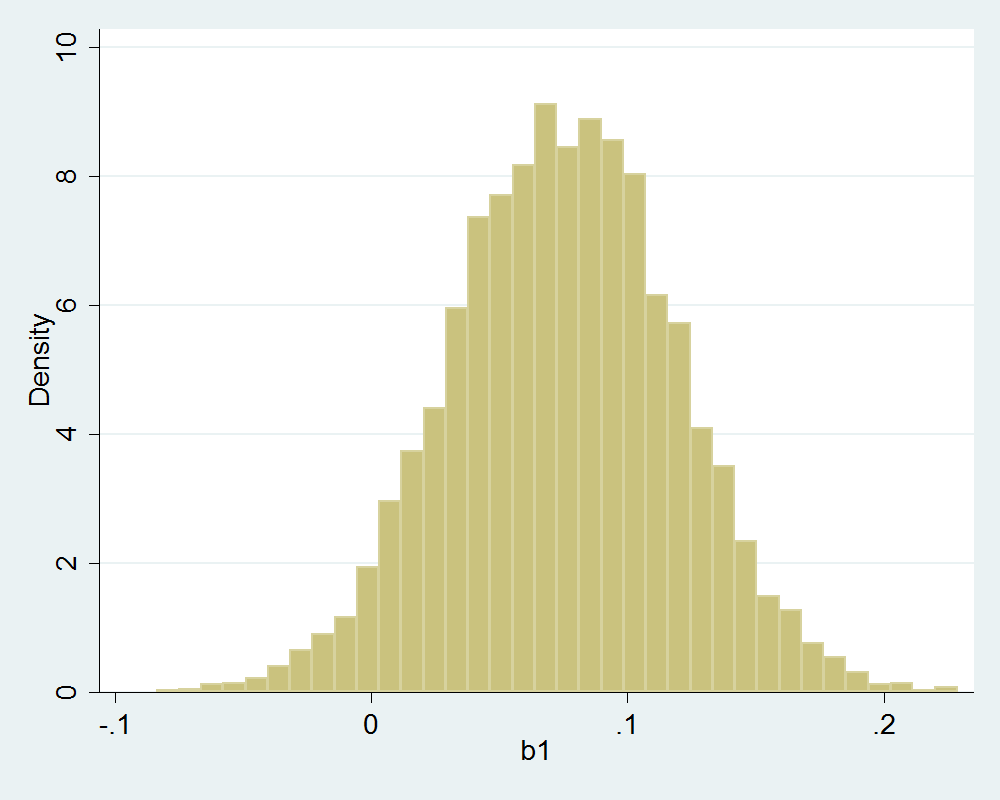

In [28]:
%%stata --graph
hist b1

Once again, the above is the simulated distribution of the treatment effect parameter. Another thing we can do is take a look at what our random effects look like (the unobserved heterogeneity parameter). The last draw of this parameter is still held in `Mata`, so:

In [29]:
%%stata
restore
preserve
clear
getmata ui


(bin=34, start=-4.0848823, width=.22565207)


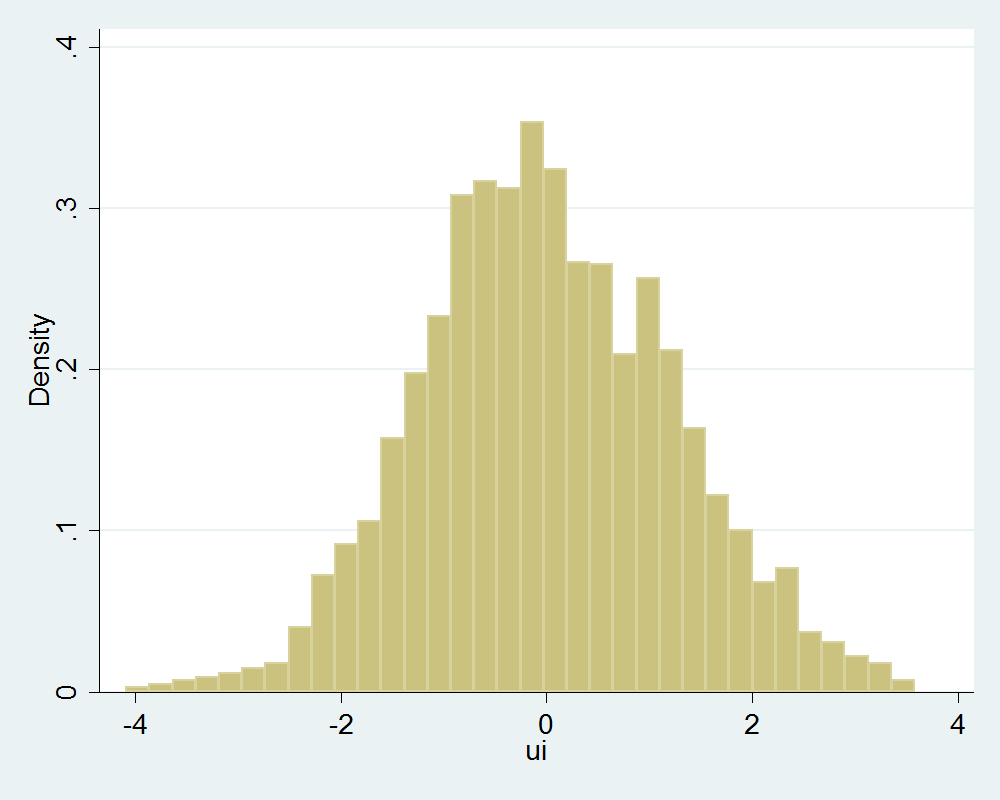

In [30]:
%%stata --gr
hist ui

Let's also have a look at the estimated distribution of our $\pi$ parameter, which characterizes cross-equation correlation:


(bin=36, start=-.24958341, width=.01387067)


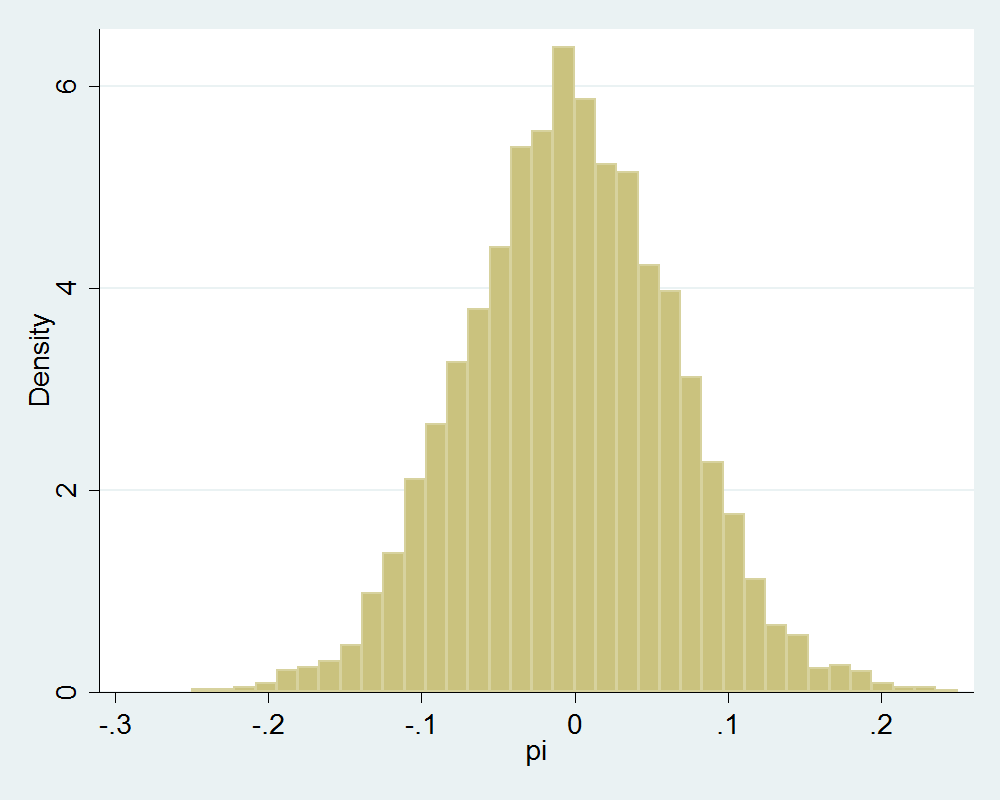

In [34]:
%%stata --gr
restore
preserve
clear
getmata pi = piHold
hist pi

We see that there really isn't all that much cause for concern - it looks like it is more or less centered at zero, meaning that there isn't a lot of correlation in the error terms of the treatment and control equations. 

It seems more or less normal, which is what we assumed it would look like. 

## Conclusions and next steps

This simple example is hopefully enough to get some of the basic ideas in place and give a feel for how a Bayesian estimation procedure might work. However, it is hard to see what the usefulness of the method is in this simple case, as estimation with correlation between equations is fairly simple in Maximum Likelihood. 

In the next few examples, it will become more obvious how the Bayesian method helps. There are two more notebooks which discuss cases with increasing complexity. So, we first discuss an example with a dichotomous treatment and continuous response (i.e., assignment to a control and treatment group), and then an example with a dichotomous treatment and response (i.e., treatment-control, good or bad outcome). In these cases, the use of latent variables allows us to distinguish between different types of cross-equation correlation, and also gives a little insight into things we never observe. 